In [51]:
import os
import numpy as np
import xarray as xr

from scripts import mapOutputs2D as mout

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

> In goSPL, it is possible to use different flow-routing algorithms by specifying the number of directions appropriately weighted by the slope that rivers could potentially take when moving downhill.

**In this example, we run a series of three experiments in which the flow-routing calculations are based on one (SFD), two, and multiple (MFD) flow direction approaches.**


#### Mesh creation

Here, the initial surface consists of a rotationally symmetric surface  composed of valleys and ridges. The triangulated grid of 100 by 100 km is built with a resolution of 200 m. The three experiments with varying water-routing directions are run for 100,000 years with a Δt of 1000 years under a 1 m/yr uniform precipitation. 

In addition to stream incision (bedrock erodibility K set to 4.e-6), hillslope processes are also accounted for using a diffusion coefficient D of 0.1 m2/yr.

The initial mesh (`sombrero.npz`) has already been generated and is available in the the `data` folder. Below we provide the code needed to regenerate it if necessary.

In [26]:
make_mesh = False
if make_mesh:
    
    import meshio
    import meshplex
    import uxarray as uxr
    from scripts import umeshFcts as ufcts

    dx = 200 # desired resolution
    nx = 500 # desired number of nodes along the x-axis
    ny = 500 # desired number of nodes along the y-axis

    xcoords = np.arange(nx)*float(dx) 
    ycoords = np.arange(ny)*float(dx) 

    x1 = np.arange(-6.25, 6.25, 0.025)
    y1 = np.arange(-6.25, 6.25, 0.025)

    X1, Y1 = np.meshgrid(x1, y1)

    coords1 = np.vstack([X1.ravel(), Y1.ravel()])

    xx = coords1[0,:]
    yy = coords1[1,:]

    radius  = np.sqrt((xx**2 + yy**2))
    theta   = np.arctan2(yy,xx)

    height  = np.exp(-0.025*(xx**2 + yy**2)**2) + 0.25 * (0.15*radius)**4  * np.cos(10.0*theta)**2 
    height  += 0.5 * (1.0-0.3*radius)

    height = np.multiply(height,333.)+75.
    noise = np.random.normal(0, 1., height.shape)

    ids = np.where(height>100)[0]
    height += noise*0.75
    height[ids] += noise[ids]*2.0
    
    ds = xr.Dataset({
        'elev': xr.DataArray(
                    data   = height.reshape(X1.shape),
                    dims   = ['y','x'],
                    coords = {'x': xcoords,'y': ycoords},
                    ),
            }
        )
    ds['cellwidth'] = (['y','x'],dx*np.ones( (ny, nx)))

    output_path = "sombrero" 
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    # Build your planar mesh
    ufcts.planarMesh(ds,output_path,fvtk='planar.vtk',fumpas=True,voro=True)

    # Loading the UGRID file
    ufile = output_path+'/base2D.nc'
    var_name = 'data'
    ugrid = uxr.open_grid(ufile) 

    # Perform the interpolation (bilinear) 
    ufcts.inter2UGRID(ds[['elev']],ugrid,output_path,var_name,type='face',latlon=False)

    data_file = [output_path+'/'+var_name+'.nc']
    # Get the information related to the mesh: primal and dual mesh
    primal_mesh = uxr.open_dataset(ufile, *data_file, use_dual=False)
    dual_mesh = uxr.open_dataset(ufile, *data_file, use_dual=True)

    # Extract nodes and faces information
    ucoords = np.empty((dual_mesh.uxgrid.n_node,3))
    ucoords[:,0] = dual_mesh.uxgrid.node_x.values
    ucoords[:,1] = dual_mesh.uxgrid.node_y.values
    ucoords[:,2] = dual_mesh.uxgrid.node_z.values
    ufaces = primal_mesh.uxgrid.node_face_connectivity.values

    # Get information about your mesh:
    print("Number of nodes: ",len(ucoords)," | number of faces ",len(ufaces))
    edge_min = np.round(dual_mesh.uxgrid.edge_node_distances.min().values/1000.+0.,2)
    edge_max = np.round(dual_mesh.uxgrid.edge_node_distances.max().values/1000.+0.,2)
    edge_mean = np.round(dual_mesh.uxgrid.edge_node_distances.mean().values/1000.+0.,2)
    print("edge range (km): min ",edge_min," | max ",edge_max," | mean ",edge_mean)

    mesh = meshio.read(output_path+'/planar.vtk')
    vertex = mesh.points
    cells = mesh.cells[1][:][1]
    Umesh = meshplex.MeshTri(vertex, cells)
    Uarea = Umesh.control_volumes
    print('Cell area (km2): ',Uarea.min()*1.e-6,Uarea.max()*1.e-6)

    meshname = output_path+"/sombrero"
    np.savez_compressed(meshname, v=vertex, c=cells, 
                    z=primal_mesh.elev.data,
                    )

You will find a series of 3 goSPL input files:
- input-sfd.yml
- input-2ngb.yml
- input-mfd.yml

These files use the same elevation and forcing conditions, the only difference being the number of downstream nodes used when computing flow directions.

## Running the simulations

To run the different simulations, you will need to do the following in a terminal:

```bash
mpirun -np X python3 runModel.py -i input-XX.yml 
```

where X is the number of processors to use (for example 5), and XX is the time step based on the input file name (for example 1k)

## Visualising the outputs

You can visualise the outputs of your simulations directly in Paraview. Below we also show how this could be extracted as netcdf grids and analysed in Python.


To do so, we will be using the `mapOutputs` Python class (available in the `scripts` folder) to first extract the outputs, remap the unstructured variables on a structured mesh. The class is also performing additional calculations on the dataset to extract individual catchments based on flow accumulation and elevation.

The interpolated model's variables are then exported as `netCDF` files, and each of them contains the following (if available from the simulation):

+ elevation `elevation` (m)
+ cumulative erosion/deposition `erodep` (m)
+ erosion/deposition rate `erodep_rate` (m/yr)
+ water flux discharge (accounting for lakes) `fillDischarge`(m3/yr)
+ sediment flux in rivers `sedimentLoad` (m3/yr)
+ main basin ids `basinID` (integer)
+ rainfall `precipitation` (m/yr)
+ tectonic `uplift` (m/yr)
+ cumulative flexural isostasy `flex` (m)

In [28]:
# Define output folder name for the simulation
out_path = 'results/'

if not os.path.exists(out_path):
    os.makedirs(out_path)
    
# The step corresponds to the output we want to generate, here we chose 10 as an example
stp = 20

# Name of each netcdf output file
ncout = os.path.join(out_path, "2ngb_stp")

# Initialisation of the class
grid2 = mout.mapOutputs(path='./', filename='input-2ngb.yml', step=stp, 
                       uplift=False, flex=False, model="utm")

# Remap the variables on the regular mesh using distance weighting interpolation
grid2.buildUTMmesh(res=200., nghb=4, smth=1)

# Export corresponding regular mesh variables as netCDF file
grid2.exportNetCDF(ncfile = ncout+str(stp)+'.nc')

Similarly we extract the grids for the other simulations:

In [29]:
# Single flow direction simulation
ncout = os.path.join(out_path, "sfd_stp")
grid1 = mout.mapOutputs(path='./', filename='input-sfd.yml', step=stp, 
                       uplift=False, flex=False, model="utm")
grid1.buildUTMmesh(res=200., nghb=4, smth=1)
grid1.exportNetCDF(ncfile = ncout+str(stp)+'.nc')

# Multiple flow direction simulation
ncout = os.path.join(out_path, "mfd_stp")
grid3 = mout.mapOutputs(path='./', filename='input-mfd.yml', step=stp, 
                       uplift=False, flex=False, model="utm")
grid3.buildUTMmesh(res=200., nghb=4, smth=1)
grid3.exportNetCDF(ncfile = ncout+str(stp)+'.nc')


To extract the information for each time step, we do:

In [32]:
def getOutputs(finput,ncout,maxstp,res):

    grid = mout.mapOutputs(path='./', filename=finput, step=0, 
                        uplift=False, flex=False, model="utm")
    grid.buildUTMmesh(res=res, nghb=4, smth=1.)
    grid.exportNetCDF(ncfile = ncout+str(0)+'.nc')
    for k in range(0, maxstp+1):
        if k>0:
            grid.getData(k)
        grid.buildUTMmesh(res=res, nghb=4, smth=0.)
        grid.exportNetCDF(ncfile = ncout+str(k)+'.nc')

    return

In [33]:
getOutputs('input-sfd.yml',os.path.join(out_path, "sfd_stp"),20,200)

getOutputs('input-2ngb.yml',os.path.join(out_path, "2ngb_stp"),20,200)

getOutputs('input-mfd.yml',os.path.join(out_path, "mfd_stp"),20,200)

We can visualise a specific output 

In [34]:
sim1 = xr.open_dataset("results/sfd_stp20.nc")
sim2 = xr.open_dataset("results/2ngb_stp20.nc")
sim3 = xr.open_dataset("results/mfd_stp20.nc")

/var/folders/n3/vd5l_ngx2hl52j9g7wgj3dqh0000gn/T/ipykernel_17642/889375300.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


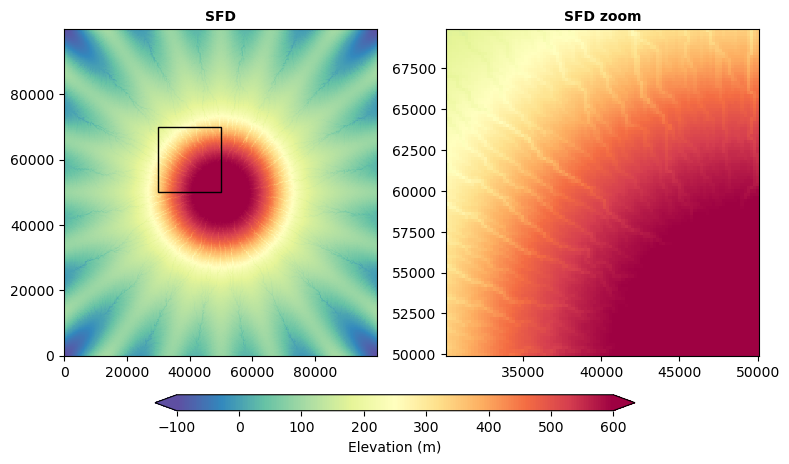

/var/folders/n3/vd5l_ngx2hl52j9g7wgj3dqh0000gn/T/ipykernel_17642/889375300.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


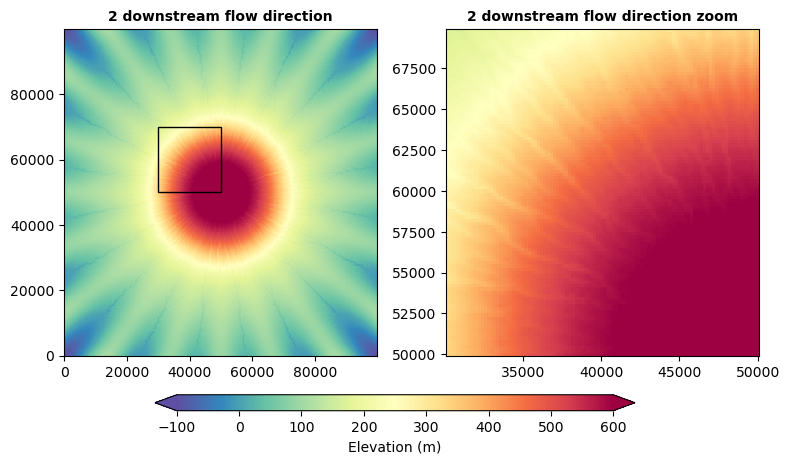

/var/folders/n3/vd5l_ngx2hl52j9g7wgj3dqh0000gn/T/ipykernel_17642/889375300.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


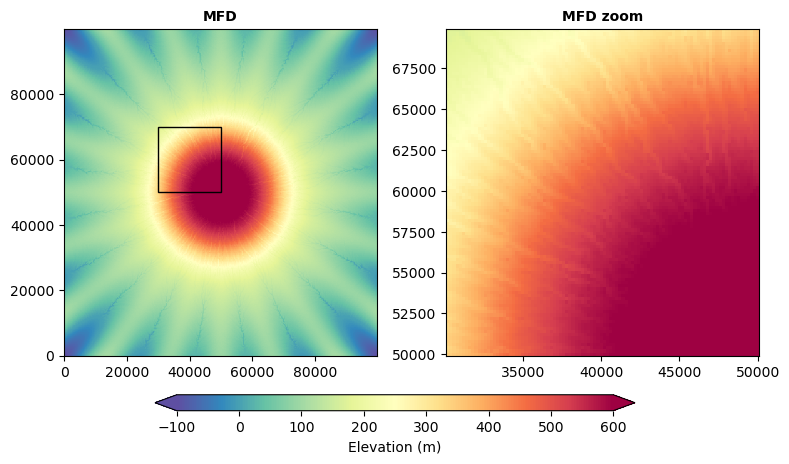

In [84]:
geometries = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [30000., 50000.],
            [30000., 70000.],
            [50000., 70000.],
            [50000., 50000.]
        ]]
    }
]


fig, ax = plt.subplots(1,2, figsize=(8,4))
sim1.rio.write_crs('epsg:4326', inplace=True)
im = sim1.elevation.plot(ax=ax[0], add_labels=False, add_colorbar=False, vmin=-100, vmax=600, cmap='Spectral_r')
# Create a Rectangle patch
rect = patches.Rectangle((30000, 50000), 20000, 20000, linewidth=1, edgecolor='k', facecolor='none')
# Add the patch to the Axes
ax[0].add_patch(rect)

ax[0].set_title('SFD', fontsize=10, fontweight="bold")

# Clip your region
clipped = sim1.rio.clip(geometries)
clipped.elevation.plot(ax=ax[1], add_labels=False, add_colorbar=False, vmin=-100, vmax=600, cmap='Spectral_r')

ax[1].set_title('SFD zoom', fontsize=10, fontweight="bold")

cbar_ax = fig.add_axes([0.2, -0.04, 0.6, 0.04]) 
cbar = fig.colorbar(im, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('Elevation (m)')

plt.tight_layout()
plt.show()

################################

fig, ax = plt.subplots(1,2, figsize=(8,4))
sim2.rio.write_crs('epsg:4326', inplace=True)
im = sim2.elevation.plot(ax=ax[0], add_labels=False, add_colorbar=False, vmin=-100, vmax=600, cmap='Spectral_r')
# Create a Rectangle patch
rect = patches.Rectangle((30000, 50000), 20000, 20000, linewidth=1, edgecolor='k', facecolor='none')
# Add the patch to the Axes
ax[0].add_patch(rect)

ax[0].set_title('2 downstream flow direction', fontsize=10, fontweight="bold")

# Clip your region
clipped = sim2.rio.clip(geometries)
clipped.elevation.plot(ax=ax[1], add_labels=False, add_colorbar=False, vmin=-100, vmax=600, cmap='Spectral_r')

ax[1].set_title('2 downstream flow direction zoom', fontsize=10, fontweight="bold")

cbar_ax = fig.add_axes([0.2, -0.04, 0.6, 0.04]) 
cbar = fig.colorbar(im, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('Elevation (m)')

plt.tight_layout()
plt.show()

################################

fig, ax = plt.subplots(1,2, figsize=(8,4))
sim3.rio.write_crs('epsg:4326', inplace=True)
im = sim3.elevation.plot(ax=ax[0], add_labels=False, add_colorbar=False, vmin=-100, vmax=600, cmap='Spectral_r')
# Create a Rectangle patch
rect = patches.Rectangle((30000, 50000), 20000, 20000, linewidth=1, edgecolor='k', facecolor='none')
# Add the patch to the Axes
ax[0].add_patch(rect)

ax[0].set_title('MFD', fontsize=10, fontweight="bold")

# Clip your region
clipped = sim3.rio.clip(geometries)
clipped.elevation.plot(ax=ax[1], add_labels=False, add_colorbar=False, vmin=-100, vmax=600, cmap='Spectral_r')

ax[1].set_title('MFD zoom', fontsize=10, fontweight="bold")

cbar_ax = fig.add_axes([0.2, -0.04, 0.6, 0.04]) 
cbar = fig.colorbar(im, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('Elevation (m)')

plt.tight_layout()
plt.show()

/var/folders/n3/vd5l_ngx2hl52j9g7wgj3dqh0000gn/T/ipykernel_17642/846453634.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


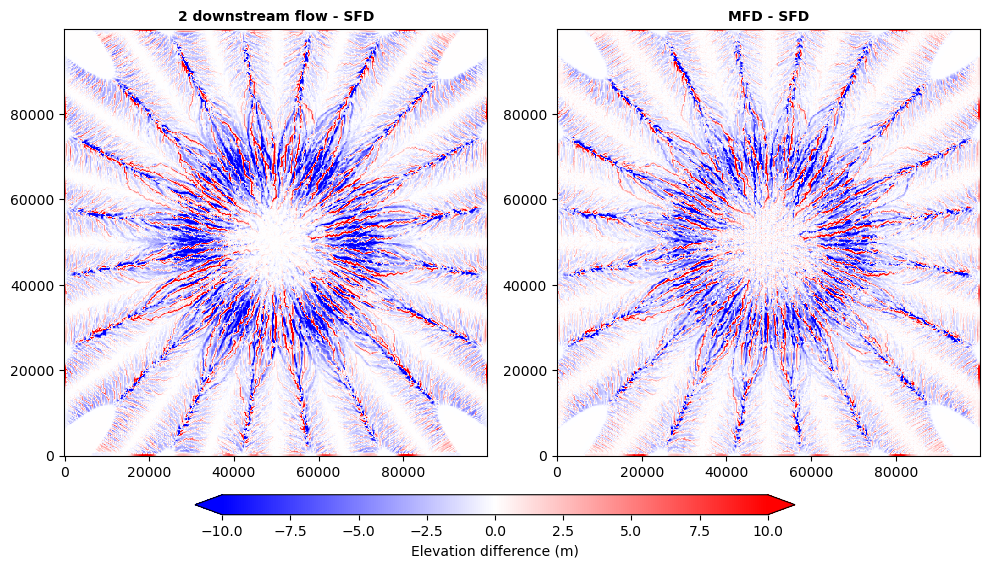

In [91]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
im = (sim2.elevation-sim1.elevation).plot(ax=ax[0], add_labels=False, add_colorbar=False, vmin=-10, vmax=10, cmap='bwr')
ax[0].set_title('2 downstream flow - SFD', fontsize=10, fontweight="bold")

(sim3.elevation-sim1.elevation).plot(ax=ax[1], add_labels=False, add_colorbar=False, vmin=-10, vmax=10, cmap='bwr')
ax[1].set_title('MFD - SFD', fontsize=10, fontweight="bold")

cbar_ax = fig.add_axes([0.2, -0.04, 0.6, 0.04]) 
cbar = fig.colorbar(im, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('Elevation difference (m)')

plt.tight_layout()
plt.show()

## Flow discharge

Let's look at the flow discharge btw the different experiments.

In [115]:
fa1 = xr.open_dataset("results/sfd_stp2.nc")
nfa1 = fa1.where(fa1.elevation>0)
fa2 = xr.open_dataset("results/2ngb_stp2.nc")
nfa2 = fa2.where(fa1.elevation>0)
fa3 = xr.open_dataset("results/mfd_stp2.nc")
nfa3 = fa3.where(fa3.elevation>0)

/var/folders/n3/vd5l_ngx2hl52j9g7wgj3dqh0000gn/T/ipykernel_17642/729342339.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


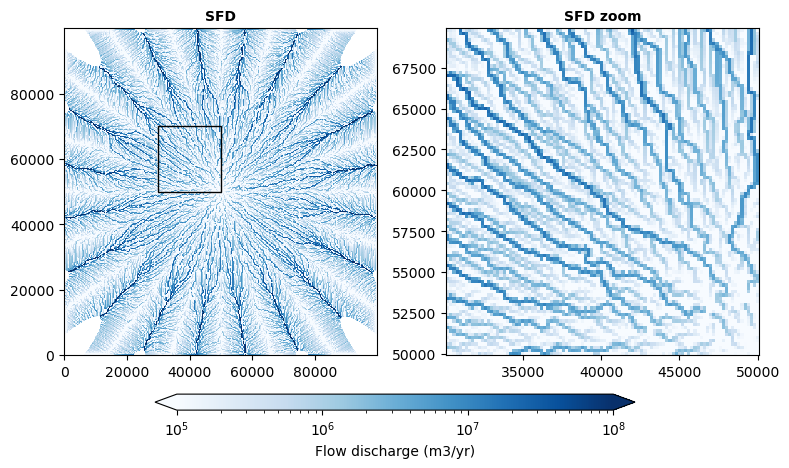

/var/folders/n3/vd5l_ngx2hl52j9g7wgj3dqh0000gn/T/ipykernel_17642/729342339.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


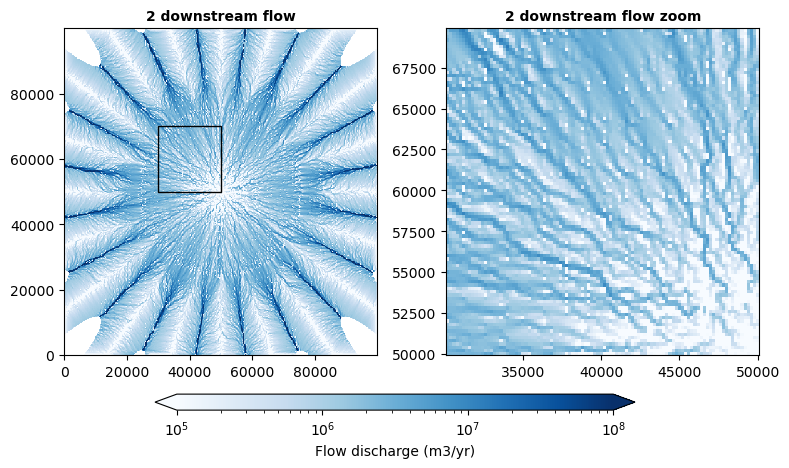

/var/folders/n3/vd5l_ngx2hl52j9g7wgj3dqh0000gn/T/ipykernel_17642/729342339.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


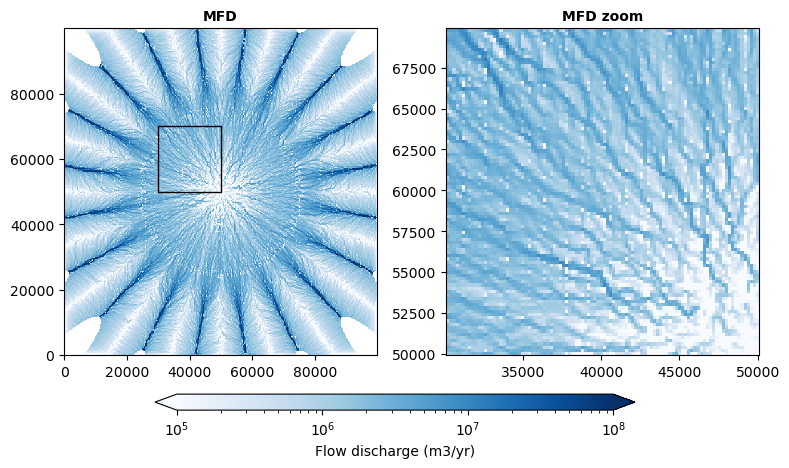

In [116]:
geometries = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [30000., 50000.],
            [30000., 70000.],
            [50000., 70000.],
            [50000., 50000.]
        ]]
    }
]

fig, ax = plt.subplots(1,2, figsize=(8,4))
nfa1.rio.write_crs('epsg:4326', inplace=True)
im = nfa1.flowDischarge.plot(ax=ax[0], add_labels=False, add_colorbar=False, norm=matplotlib.colors.LogNorm(vmin=1e5, vmax=1e8),cmap='Blues')
# Create a Rectangle patch
rect = patches.Rectangle((30000, 50000), 20000, 20000, linewidth=1, edgecolor='k', facecolor='none')
# Add the patch to the Axes
ax[0].add_patch(rect)

ax[0].set_title('SFD', fontsize=10, fontweight="bold")

# Clip your region
clipped = nfa1.rio.clip(geometries)
clipped.flowDischarge.plot(ax=ax[1], add_labels=False, add_colorbar=False, norm=matplotlib.colors.LogNorm(vmin=1e5, vmax=1e8),cmap='Blues')

ax[1].set_title('SFD zoom', fontsize=10, fontweight="bold")

cbar_ax = fig.add_axes([0.2, -0.04, 0.6, 0.04]) 
cbar = fig.colorbar(im, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('Flow discharge (m3/yr)')

plt.tight_layout()
plt.show()

################################

fig, ax = plt.subplots(1,2, figsize=(8,4))
nfa2.rio.write_crs('epsg:4326', inplace=True)
im = nfa2.flowDischarge.plot(ax=ax[0], add_labels=False, add_colorbar=False, norm=matplotlib.colors.LogNorm(vmin=1e5, vmax=1e8),cmap='Blues')
# Create a Rectangle patch
rect = patches.Rectangle((30000, 50000), 20000, 20000, linewidth=1, edgecolor='k', facecolor='none')
# Add the patch to the Axes
ax[0].add_patch(rect)

ax[0].set_title('2 downstream flow', fontsize=10, fontweight="bold")

# Clip your region
clipped = nfa2.rio.clip(geometries)
clipped.flowDischarge.plot(ax=ax[1], add_labels=False, add_colorbar=False, norm=matplotlib.colors.LogNorm(vmin=1e5, vmax=1e8),cmap='Blues')

ax[1].set_title('2 downstream flow zoom', fontsize=10, fontweight="bold")

cbar_ax = fig.add_axes([0.2, -0.04, 0.6, 0.04]) 
cbar = fig.colorbar(im, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('Flow discharge (m3/yr)')

plt.tight_layout()
plt.show()

################################

fig, ax = plt.subplots(1,2, figsize=(8,4))
nfa3.rio.write_crs('epsg:4326', inplace=True)
im = nfa3.flowDischarge.plot(ax=ax[0], add_labels=False, add_colorbar=False, norm=matplotlib.colors.LogNorm(vmin=1e5, vmax=1e8),cmap='Blues')
# Create a Rectangle patch
rect = patches.Rectangle((30000, 50000), 20000, 20000, linewidth=1, edgecolor='k', facecolor='none')
# Add the patch to the Axes
ax[0].add_patch(rect)

ax[0].set_title('MFD', fontsize=10, fontweight="bold")

# Clip your region
clipped = nfa3.rio.clip(geometries)
clipped.flowDischarge.plot(ax=ax[1], add_labels=False, add_colorbar=False, norm=matplotlib.colors.LogNorm(vmin=1e5, vmax=1e8),cmap='Blues')

ax[1].set_title('MFD zoom', fontsize=10, fontweight="bold")

cbar_ax = fig.add_axes([0.2, -0.04, 0.6, 0.04]) 
cbar = fig.colorbar(im, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('Flow discharge (m3/yr)')

plt.tight_layout()
plt.show()

/var/folders/n3/vd5l_ngx2hl52j9g7wgj3dqh0000gn/T/ipykernel_17642/3893072411.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


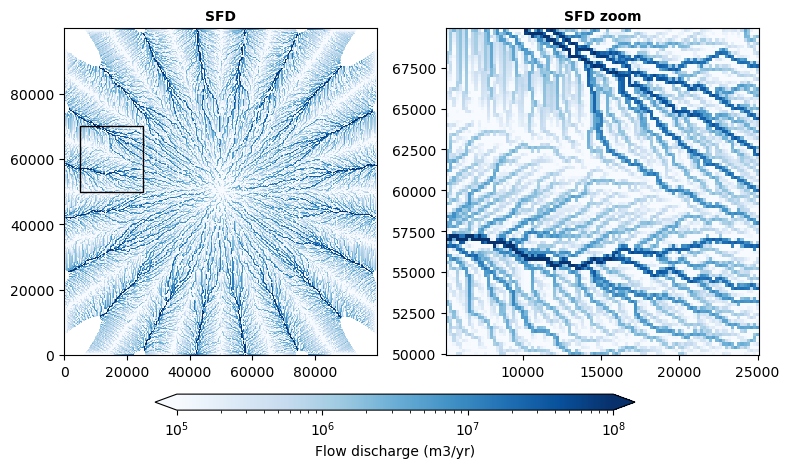

/var/folders/n3/vd5l_ngx2hl52j9g7wgj3dqh0000gn/T/ipykernel_17642/3893072411.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


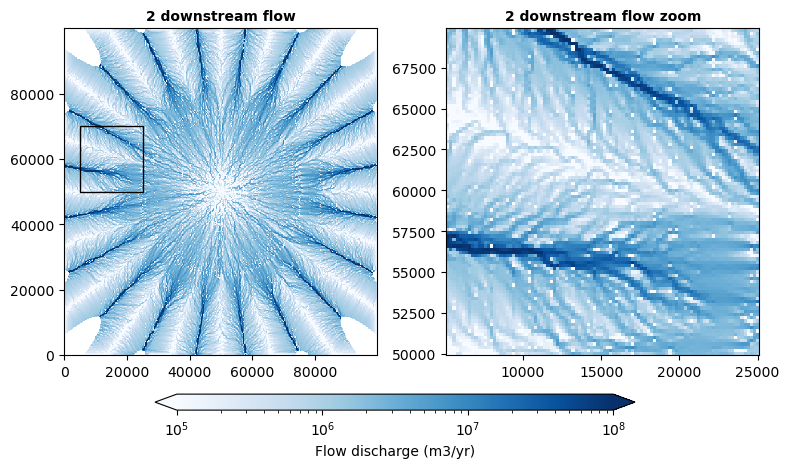

/var/folders/n3/vd5l_ngx2hl52j9g7wgj3dqh0000gn/T/ipykernel_17642/3893072411.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


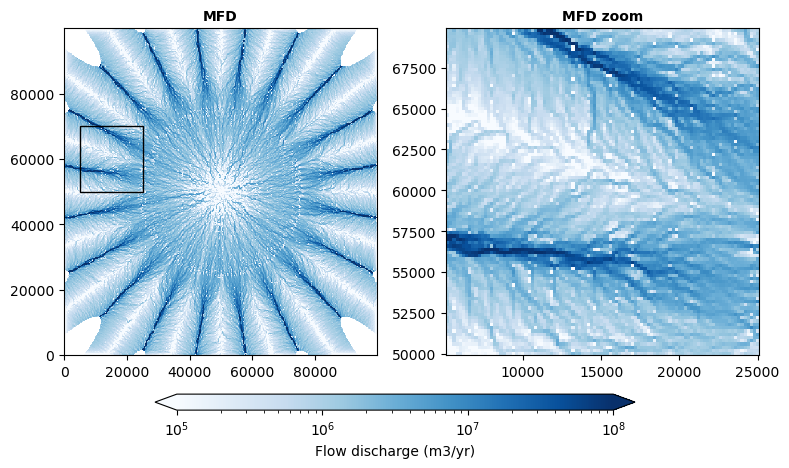

In [117]:
geometries = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [5000., 50000.],
            [5000., 70000.],
            [25000., 70000.],
            [25000., 50000.]
        ]]
    }
]

fig, ax = plt.subplots(1,2, figsize=(8,4))
nfa1.rio.write_crs('epsg:4326', inplace=True)
im = nfa1.flowDischarge.plot(ax=ax[0], add_labels=False, add_colorbar=False, norm=matplotlib.colors.LogNorm(vmin=1e5, vmax=1e8),cmap='Blues')
# Create a Rectangle patch
rect = patches.Rectangle((5000, 50000), 20000, 20000, linewidth=1, edgecolor='k', facecolor='none')
# Add the patch to the Axes
ax[0].add_patch(rect)

ax[0].set_title('SFD', fontsize=10, fontweight="bold")

# Clip your region
clipped = nfa1.rio.clip(geometries)
clipped.flowDischarge.plot(ax=ax[1], add_labels=False, add_colorbar=False, norm=matplotlib.colors.LogNorm(vmin=1e5, vmax=1e8),cmap='Blues')

ax[1].set_title('SFD zoom', fontsize=10, fontweight="bold")

cbar_ax = fig.add_axes([0.2, -0.04, 0.6, 0.04]) 
cbar = fig.colorbar(im, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('Flow discharge (m3/yr)')

plt.tight_layout()
plt.show()

################################

fig, ax = plt.subplots(1,2, figsize=(8,4))
nfa2.rio.write_crs('epsg:4326', inplace=True)
im = nfa2.flowDischarge.plot(ax=ax[0], add_labels=False, add_colorbar=False, norm=matplotlib.colors.LogNorm(vmin=1e5, vmax=1e8),cmap='Blues')
# Create a Rectangle patch
rect = patches.Rectangle((5000, 50000), 20000, 20000, linewidth=1, edgecolor='k', facecolor='none')
# Add the patch to the Axes
ax[0].add_patch(rect)

ax[0].set_title('2 downstream flow', fontsize=10, fontweight="bold")

# Clip your region
clipped = nfa2.rio.clip(geometries)
clipped.flowDischarge.plot(ax=ax[1], add_labels=False, add_colorbar=False, norm=matplotlib.colors.LogNorm(vmin=1e5, vmax=1e8),cmap='Blues')

ax[1].set_title('2 downstream flow zoom', fontsize=10, fontweight="bold")

cbar_ax = fig.add_axes([0.2, -0.04, 0.6, 0.04]) 
cbar = fig.colorbar(im, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('Flow discharge (m3/yr)')

plt.tight_layout()
plt.show()

################################

fig, ax = plt.subplots(1,2, figsize=(8,4))
nfa3.rio.write_crs('epsg:4326', inplace=True)
im = nfa3.flowDischarge.plot(ax=ax[0], add_labels=False, add_colorbar=False, norm=matplotlib.colors.LogNorm(vmin=1e5, vmax=1e8),cmap='Blues')
# Create a Rectangle patch
rect = patches.Rectangle((5000, 50000), 20000, 20000, linewidth=1, edgecolor='k', facecolor='none')
# Add the patch to the Axes
ax[0].add_patch(rect)

ax[0].set_title('MFD', fontsize=10, fontweight="bold")

# Clip your region
clipped = nfa3.rio.clip(geometries)
clipped.flowDischarge.plot(ax=ax[1], add_labels=False, add_colorbar=False, norm=matplotlib.colors.LogNorm(vmin=1e5, vmax=1e8),cmap='Blues')

ax[1].set_title('MFD zoom', fontsize=10, fontweight="bold")

cbar_ax = fig.add_axes([0.2, -0.04, 0.6, 0.04]) 
cbar = fig.colorbar(im, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('Flow discharge (m3/yr)')

plt.tight_layout()
plt.show()

After 10 000 years, the dendritic flow accumulation pattern observed on the surface for the SFD case is analogue to many natural forms of drainage systems but is actually a numerical artefact and depends on the random locations of the nodes in the surface triangulation. 

By increasing the number of possible downstream directions, this sensitivity to the mesh discretisation is significantly reduced. In addition, routing flow to more than one destination node allows for a better representation of channel pathway divergence into multiple branches over flat regions.

Landscape evolution models tend to be highly dependent on grid resolution, and this dependency is mostly related to the approach used to route water down the surface. 

Enabling the node-to-node MFD algorithm decreases the dependence of landscape features (e.g. valley spacing, branching of stream network, sediment flux) on grid resolution. As shown in the above figures, the SFD algorithm leads to increased branching of valleys, whereas the MFD approach, by promoting wider flow distribution, produces smoother topography on which local carving of the landscape is reduced.It has also been shown that when using models that operate at a scale larger than river-width resolution, the node-to-node MFD algorithm creates landscape features that are not resolution dependent and that evolve closer to the ones observed in nature. Therefore, it is recommended to use more than one downhill direction (flowdir) in goSPL when looking at global- and continental-scale landscape evolution or for cases in which multiple resolutions are considered within a given mesh.